In [59]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost

# Data Preprocessing
Data Split, Train-test Split, etc...

In [87]:
#Import Data

data = pd.read_excel(r'/Users/familiadelasherasgarciahijosdanielnuriapablo/Documents/Applied Math and Data Science/Jovia/DeidentifiedSDOHPatientData-v1.xlsx')

data.columns = ['id', 'age', 'race', 'ethnicity', 'gender',
       'Q1',
       'Q2',
       'Q3',
       'Q4',
       'Q5',
       'Q6',
       'Q7',
       'Q8']

# Only get the first three columns - predictor, and only question column - label
data = data[['age', 'race', 'ethnicity', 'gender',
       'Q1']]

# Drop Patient declined, Patient unable to answer
target_rows     = (data['Q1']=='Patient declined')| (data['Q1']=='Patient unable to answer') | (data['Q1'].isnull())

future_predict  = data[target_rows]

future_predict.drop(columns = ['Q1'], inplace = True)

data       = data[~target_rows]

/var/folders/g3/ncfg5yhn47v7z7k0wmn723zc0000gn/T/ipykernel_23504/3433434604.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_predict.drop(columns = ['Q1'], inplace = True)


In [88]:
# One Hot Encoding
dummies = pd.get_dummies(data[['race', 'ethnicity', 'gender']], drop_first=True, dtype=float)

data.drop(columns = ['race', 'ethnicity', 'gender'], inplace =True)

data = pd.concat([data, dummies], axis = 1)

In [89]:
X = data.drop(columns = 'Q1')
y = data['Q1']

# Label Encoding
mapping = {'Never True':0,
       'Sometimes True':1, 'Often True':1}

reverse_mapping = {0:'False', 1:'True'}

y = y.map(mapping)

In [90]:
from sklearn.model_selection import train_test_split

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0, stratify=y)

In [64]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_smt_train, y_smt_train = oversample.fit_resample(X_train, y_train)

In [65]:
xg_train = xgboost.DMatrix(X_smt_train, label=y_smt_train)
xg_test = xgboost.DMatrix(X_test, label=y_test)

In [78]:
from sklearn.metrics import make_scorer, precision_score, recall_score

def custom_scorer(y_true, y_pred):
    recall_label_0 = recall_score(y_true, y_pred, pos_label=0)
    recall_label_1 = recall_score(y_true, y_pred, pos_label=1)
    precision_label_0 = precision_score(y_true, y_pred, pos_label=0)
    precision_label_1 = precision_score(y_true, y_pred, pos_label=1)
    weighted_recall = 0 * recall_label_1 + 0 * recall_label_0 +   1 * precision_label_0 + 0 * precision_label_1# Weighted average with more weight on label 1
    return weighted_recall
scorer = make_scorer(custom_scorer)

In [79]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "scale_pos_weight" : [1,2,3,4,5,10,20,40,50,60,80,90,100,150,200]
    
}

model = xgboost.XGBClassifier()

random_search=RandomizedSearchCV(model,param_distributions=params,n_iter=5,scoring=scorer,n_jobs=-1,cv=5,verbose=3)

random_search.fit(X_train,y_train)

random_search.best_params_


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 2/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, scale_pos_weight=60;, score=0.987 total time=   0.2s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.25, max_depth=6, min_child_weight=3, scale_pos_weight=5;, score=0.985 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.25, max_depth=6, min_child_weight=3, scale_pos_weight=5;, score=0.985 total time=   0.1s
[CV 5/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, scale_pos_weight=60;, score=0.989 total time=   0.2s
[CV 3/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, scale_pos_weight=60;, score=0.992 total time=   0.2s
[CV 1/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, scale_pos_weight=60;, score=0.985 total time=   0.2s
[CV 4/5] END colsample_bytree=0.5,

{'scale_pos_weight': 50,
 'min_child_weight': 7,
 'max_depth': 4,
 'learning_rate': 0.3,
 'gamma': 0.4,
 'colsample_bytree': 0.4}

## XGBoost

0.5574365175332527
              precision    recall  f1-score   support

           0       0.99      0.56      0.71      4074
           1       0.02      0.61      0.04        61

    accuracy                           0.56      4135
   macro avg       0.50      0.58      0.38      4135
weighted avg       0.98      0.56      0.70      4135



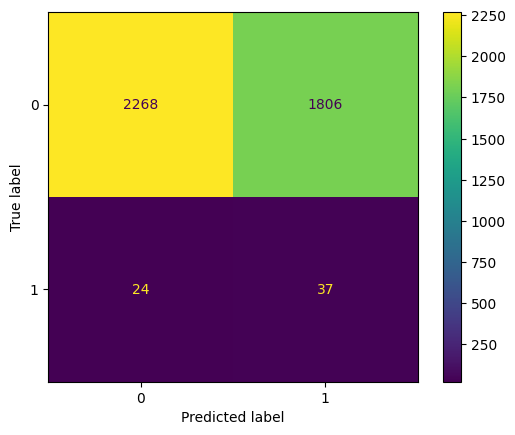

In [80]:
xgb = xgboost.XGBClassifier(
    scale_pos_weight=50,
    min_child_weight= 7,
    max_depth= 4,
    learning_rate= 0.3,
    gamma= 0.4,
    colsample_bytree= 0.4
 )
xgb.fit(X_smt_train,y_smt_train)

y_pred = xgb.predict(X_test)

print(accuracy_score(y_test,y_pred))
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
dist= ConfusionMatrixDisplay(cm)
dist.plot()

## Naive Bayes

0.0249093107617896
              precision    recall  f1-score   support

           0       1.00      0.01      0.02      4074
           1       0.01      1.00      0.03        61

    accuracy                           0.02      4135
   macro avg       0.51      0.51      0.02      4135
weighted avg       0.99      0.02      0.02      4135



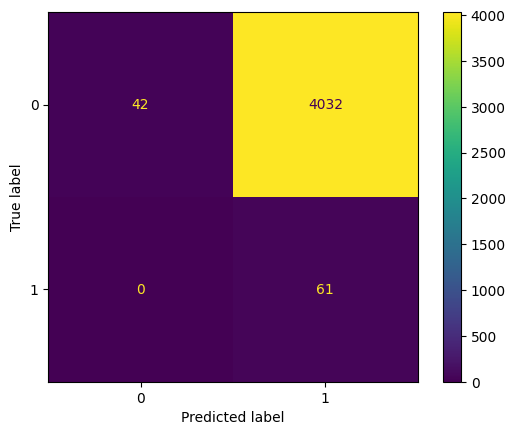

In [91]:
from sklearn.naive_bayes import GaussianNB

# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

# Predict Output
predicted = model.predict(X_test)

print(accuracy_score(y_test,predicted))
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, predicted))
cm = confusion_matrix(y_test, predicted)
dist= ConfusionMatrixDisplay(cm)
dist.plot()